Based on *Using a deep temporal convolutional network as a building energy surrogate model that spans multiple climate zones*
Recreation of Westermann et al., 2020

https://doi.org/10.1016/j.apenergy.2020.115563

https://gitlab.com/energyincities/building_surrogate_modelling

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import h5py
import os

# torch.cuda.empty_cache()

Couldn't import dot_parser, loading of dot files will not be possible.


### CUDA checks

In [2]:
# print(f'PyTorch version: {torch.__version__}')
# print('*'*10)
# print(f'_CUDA version: ')
# !nvcc --version
# print('*'*10)
# print(f'CUDNN version: {torch.backends.cudnn.version()}')
# print(f'Available GPU devices: {torch.cuda.device_count()}')
# print(f'Device Name: {torch.cuda.get_device_name()}')
# print(torch.cuda.memory_summary())

In [2]:
# is_cuda_runtime =  torch.cuda.is_available()
# if not is_cuda_runtime:
#   print("Change your runtime to a GPU-accelerated one.")
# else:
#   print("All good!")
# device = "cuda" if is_cuda_runtime else "cpu"\
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.memory_allocated()

0

# Imports

In [3]:
from storage import upload_to_bucket, download_from_bucket
from schedules import mutate_timeseries
from simulate import BatchSimulator
from schema import Schema

schema = Schema()

ERROR:Schema:Failed to import a package! Be wary about continuing...
Traceback (most recent call last):
  File "/home/paperspace/ml-for-building-energy-modeling/ml-for-bem/schema.py", line 25, in <module>
    from pyumi.shoeboxer.shoebox import ShoeBox
ModuleNotFoundError: No module named 'pyumi'


In [5]:
# !pip install vapeplot &> /dev/null

In [4]:
# @markdown ### 0.4 | Styling
# import google
# import vapeplot # https://github.com/dantaki/vapeplot
import matplotlib
# is_dark = google.colab.output.eval_js(
#     'document.documentElement.matches("[theme=dark]")'
# )

matplotlib.rcParams["figure.dpi"] = 100
matplotlib.rcParams["savefig.dpi"] = 300
# load style sheet for matplotlib, a plotting library we use for 2D visualizations
plt.style.use(
    "https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle"
)
plt.style.use("dark_background")
plt.rcParams.update(
    {
        "figure.facecolor": (0.22, 0.22, 0.22, 1.0),
        "axes.facecolor": (0.22, 0.22, 0.22, 1.0),
        "savefig.facecolor": (0.22, 0.22, 0.22, 1.0),
        "grid.color": (0.4, 0.4, 0.4, 1.0),
    }
)
# vapeplot.set_palette("mallsoft")
plt.set_cmap("plasma");

<Figure size 640x480 with 0 Axes>

# Download & preprocess the data

## Weather file & schedules preprocessing

In [7]:
# download_from_bucket(blob_name=f"climate_array.npy", file_name="./data/epws/climate_array.npy")
# download_from_bucket(blob_name=f"tsol.npy", file_name="./data/epws/tsol.npy")
# download_from_bucket(blob_name=f"default_schedules.npy", file_name="./data/template_libs/default_schedules.npy")
# download_from_bucket(blob_name=f"all_data_monthly.hdf5", file_name="./data/hdf5/all_data_monthly.hdf5")

In [5]:
climate_array = np.load("./data/epws/climate_array.npy")
tsol_array = np.load("./data/epws/tsol.npy")
tsol_array = np.load("./data/epws/tsol.npy")
schedules = np.load("./data/template_libs/default_schedules.npy") # 3x8760

[13.3 11.6 10.1 ... 16.8 16.2 14.9]


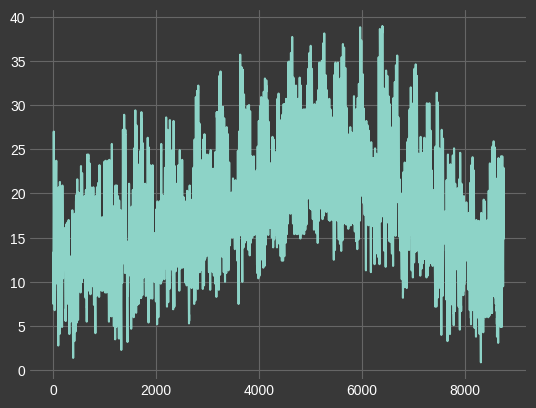

In [6]:
climate_array.shape
plt.plot(climate_array[0,0])
print(climate_array[0,0])

Make a file in data called "hdf5"

## Normalization

First, let's set up the timeseries data

In [7]:
# TODO: normalize with the batch std? or recorded
# nornalization method?
# def normalize(data, mean, std):
    # return (data-mean)/std
def normalize(data, maxv, minv):
    return (data-minv)/(maxv-minv)

In [8]:
dbt_max = 50.0 # 50.5
dbt_min = -35.0
rh_max = 100.0
rh_min = 0.0 # 2.0
atm_max = 105800.0
atm_min = 75600.0
rad_min = 0.0
ghrad_max = 1200.0 #1154.0
dnrad_max = 1097.0
dhrad_max = 689.0
skyt_max = 32.3
skyt_min = -58.3
tsol_max = 60
tsol_min = -40

In [9]:
# Normalize the whole climate and tsol array
maxes = [dbt_max, rh_max, atm_max, ghrad_max, dnrad_max, dhrad_max, skyt_max]
mins = [dbt_min, rh_min, atm_min, rad_min, rad_min, rad_min, skyt_min]

norm_climate_array = np.zeros(climate_array.shape)
norm_tsol_array = np.zeros(tsol_array.shape)
for j in range(climate_array.shape[0]):
    for i in range(7):
        norm_climate_array[j, i, :] = normalize(climate_array[j, i, :], maxes[i], mins[i])
    for i in range(4):
        norm_tsol_array[j, i, :] = normalize(tsol_array[j, i, :], tsol_max, tsol_min)

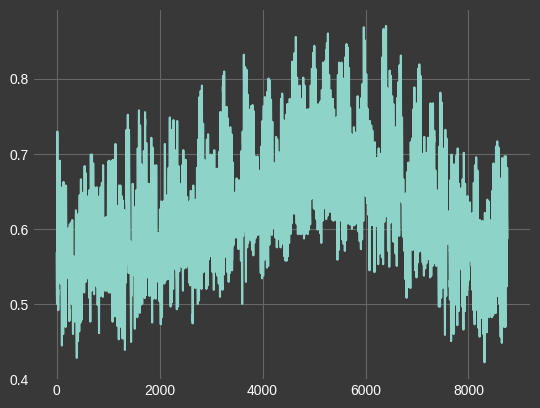

In [10]:

plt.plot(norm_climate_array[0,0])

Schedules

Now for the building vector

In [11]:
building_vect_schema = [
    'width', 
    'height', 
    'facade_2_footprint', 
    'perim_2_footprint',
    'roof_2_footprint',
    'footprint_2_ground',
    'wwr',
    'orientation',
    'HeatingSetpoint',
    'CoolingSetpoint',
    'LightingPowerDensity',
    'EquipmentPowerDensity',
    'PeopleDensity',
    'Infiltration',
    'FacadeMass',
    'RoofMass',
    'FacadeRValue',
    'RoofRValue',
    'SlabRValue',
    ]

building_vector_size = len(building_vect_schema) + 3 # (area/windowsettings)


And finally, the output energy data 

In [15]:
# for i in range(1000):
#     plt.plot(norm_results[i, 0, :], 'orange', alpha=0.2)
#     plt.plot(norm_results[i, 1, :], 'lightblue', alpha=0.5)
# plt.plot(np.mean(norm_results[:, 0, :], axis=0), 'orangered', label="Heating")
# plt.plot(np.mean(norm_results[:, 1, :], axis=0), 'dodgerblue', label="Cooling")
# plt.legend()
# plt.show()

# Sample Loader from Dataset

In [12]:
# the loading & preprocessing grouped into a function
def load_training_samples(schema,
    start_idx = 0,
    count = 20000,
    dbt_max = 50.0, # 50.5
    dbt_min = -35.0,
    rh_max = 100.0,
    rh_min = 0.0, # 2.0
    atm_max = 105800.0,
    atm_min = 75600.0,
    rad_min = 0.0,
    ghrad_max = 1200.0, #1154.0
    dnrad_max = 1097.0,
    dhrad_max = 689.0,
    skyt_max = 32.3,
    skyt_min = -58.3,
    tsol_max = 60,
    tsol_min = -40,
    a_max = 2000,
    a_min = 0,
    energy_min = 0,
    energy_max = 30, # 30 kWh/m2/mo
):
    with h5py.File(f"./data/hdf5/all_data_monthly.hdf5", 'r') as f:
        batch_size=count
        monthly = f["monthly"][start_idx:start_idx+batch_size] # this loads the whole batch into memory!
        # total_heating = f["total_heating"][0:batch_size] # this loads the whole batch into memory!
        # total_cooling = f["total_cooling"][0:batch_size] # this loads the whole batch into memory!
        # errors = f["errors"][...]
        area = f["area"][start_idx:start_idx+batch_size]
        batch = f["storage_batch"][start_idx:start_idx+batch_size]
    # Normalize the whole climate and tsol array
    maxes = [dbt_max, rh_max, atm_max, ghrad_max, dnrad_max, dhrad_max, skyt_max]
    mins = [dbt_min, rh_min, atm_min, rad_min, rad_min, rad_min, skyt_min]

    norm_climate_array = np.zeros(climate_array.shape)
    norm_tsol_array = np.zeros(tsol_array.shape)
    for j in range(climate_array.shape[0]):
        for i in range(7):
            norm_climate_array[j, i, :] = normalize(climate_array[j, i, :], maxes[i], mins[i])
        for i in range(4):
            norm_tsol_array[j, i, :] = normalize(tsol_array[j, i, :], tsol_max, tsol_min)

    # Schedules
    seeds = schema["schedules_seed"].extract_storage_values_batch(batch).astype(int) # 1x1
    operations_maps = schema["schedules"].extract_storage_values_batch(batch) # 3

    # timeseries_vector = np.zeros((data_size, 8, 8760))
    data_size = batch.shape[0]
    timeseries_vector = np.zeros((data_size, 11, 8760))
    orientations = schema['orientation'].extract_storage_values_batch(batch).flatten()
    idxs = schema['base_epw'].extract_storage_values_batch(batch).flatten()
    # Get the weather file for each entry
    for i, epw_idx in enumerate(idxs):
        epw_idx = int(epw_idx)
        timeseries_vector[i, :-4, :] = norm_climate_array[epw_idx]
        timeseries_vector[i, -4:-1, :] = mutate_timeseries(schedules, operations_maps[i], seeds[i])
        timeseries_vector[i, -1, :] = norm_tsol_array[epw_idx, int(orientations[i]), :]
    wind_settings = schema["WindowSettings"].extract_storage_values_batch(batch)

    

    building_vector = np.zeros((data_size, 22))
    for i, schema_name in enumerate(building_vect_schema):
        column = schema[schema_name].extract_storage_values_batch(batch).flatten()
        try:
            column = normalize(column, schema[schema_name].max, schema[schema_name].min)
        except:
            print(f"Calculating mean from batch data for {schema_name}...")
            column = normalize(column, np.max(column), np.min(column))
        building_vector[:, i] = column
    building_vector[:, -3] = normalize(area, a_max, a_min)
    building_vector[:, -2] = normalize(wind_settings[:, 0].flatten(), schema["WindowSettings"].max[0], schema["WindowSettings"].min[0]) # U-val
    building_vector[:, -1] = normalize(wind_settings[:, 1].flatten(), schema["WindowSettings"].max[1], schema["WindowSettings"].min[1]) # shgc

    # Add core and perimeter together
    heating = (monthly[:, 0, :]+monthly[:, 2, :]) / area.reshape(-1,1)
    cooling = (monthly[:, 1, :]+monthly[:, 3, :]) / area.reshape(-1,1)
    area_normed_results = np.concatenate((np.expand_dims(heating, 1), np.expand_dims(cooling, 1)), axis=1)

    norm_results = normalize(area_normed_results, energy_max*2.777e7, energy_min*2.777e7)
    # TODO: MAKE THIS EUI?

    return building_vector, timeseries_vector, norm_results

# Load Part of the Dataset into Memory

Calculating mean from batch data for orientation...


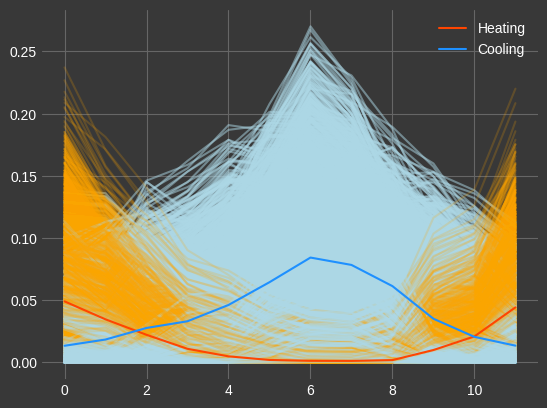

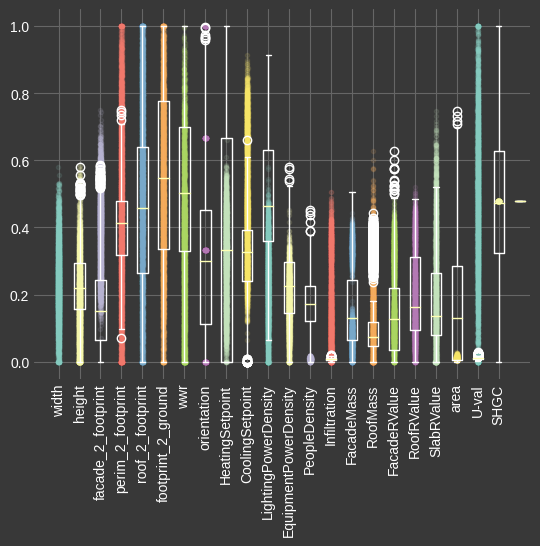

CPU times: user 11.5 s, sys: 1.35 s, total: 12.9 s
Wall time: 12.9 s


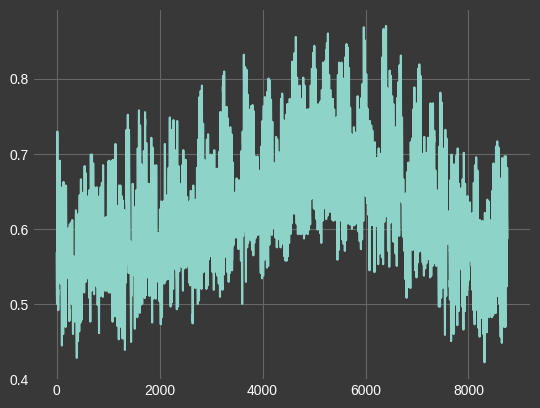

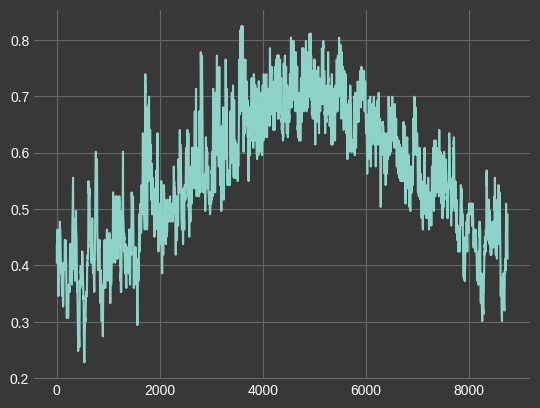

In [13]:
%%time
start_idx = 0
bldg_count = 4000

building_vector, timeseries_vector, norm_results = load_training_samples(schema, start_idx=start_idx, count=bldg_count)

for i in range(bldg_count):
    plt.plot(norm_results[i, 0, :], 'orange', alpha=0.2)
    plt.plot(norm_results[i, 1, :], 'lightblue', alpha=0.5)
plt.plot(np.mean(norm_results[:, 0, :], axis=0), 'orangered', label="Heating")
plt.plot(np.mean(norm_results[:, 1, :], axis=0), 'dodgerblue', label="Cooling")
plt.legend()
plt.show()

for c in range(len(building_vect_schema) + 3):
    y = building_vector[:, c]
    # Add some random "jitter" to the x-axis
    x = np.random.normal(c, 0.01, size=len(y))
    plt.plot(x, y, '.', alpha=0.1)
plt.boxplot(building_vector)
plt.xticks(ticks = list(range(22)), labels=building_vect_schema + ["area", "U-val", "SHGC"], rotation = 90)
plt.show()

plt.figure()
plt.plot(timeseries_vector[0,0])

plt.figure()
plt.plot(timeseries_vector[1001,0])

# Set up the model

## Timeseries CNN

In [14]:
import torch.nn as nn
import torch.optim as optim

class EnergyTimeseriesCNNBlockA(nn.Module):
    def __init__(self, 
                 in_channels=11,
                 n_feature_maps = 64,
                 ):
        super().__init__()

        self.n_feature_maps=n_feature_maps

        self.input_convolutional_layer = nn.Sequential(
            nn.Conv1d(
                in_channels=in_channels,
                out_channels=n_feature_maps,
                kernel_size=8,
                stride=1,
                padding='same',
            ),
            nn.BatchNorm1d(n_feature_maps),
        )

        self.mid_convolutional_layer = nn.Sequential(
            nn.Conv1d(
                in_channels=n_feature_maps,
                out_channels=n_feature_maps,
                kernel_size=5,
                stride=1,
                padding='same',
            ),
            nn.BatchNorm1d(n_feature_maps),
        )

        self.final_convolutional_layer = nn.Sequential(
            nn.Conv1d(
                in_channels=n_feature_maps,
                out_channels=n_feature_maps,
                kernel_size=3,
                stride=1,
                padding='same',
            ),
            nn.BatchNorm1d(n_feature_maps),
        )

        self.skip_layer = nn.Sequential(
            nn.Conv1d(
                in_channels=in_channels,
                out_channels=n_feature_maps,
                kernel_size=1,
                stride=1,
                padding=0,
            ),
            nn.BatchNorm1d(n_feature_maps), 
        )

    def forward(self, x):
        x_skip = self.skip_layer(x)
        
        x_out = self.input_convolutional_layer(x)
        x_out = nn.functional.relu(x_out)

        x_out = self.mid_convolutional_layer(x_out)
        x_out = nn.functional.relu(x_out)

        x_out = self.final_convolutional_layer(x_out)
        
        x_out = x_out + x_skip
        
        return nn.functional.relu(x_out)

class EnergyTimeseriesCNNBlockB(nn.Module):
    def __init__(self, 
                 in_channels=128,
                 n_feature_maps = 128,
                 ):
        super().__init__()

        self.n_feature_maps=n_feature_maps

        self.input_convolutional_layer = nn.Sequential(
            nn.Conv1d(
                in_channels=in_channels,
                out_channels=n_feature_maps,
                kernel_size=8,
                stride=1,
                padding='same',
            ),
            nn.BatchNorm1d(n_feature_maps),
        )

        self.mid_convolutional_layer = nn.Sequential(
            nn.Conv1d(
                in_channels=n_feature_maps,
                out_channels=n_feature_maps,
                kernel_size=5,
                stride=1,
                padding='same',
            ),
            nn.BatchNorm1d(n_feature_maps),
        )

        self.final_convolutional_layer = nn.Sequential(
            nn.Conv1d(
                in_channels=n_feature_maps,
                out_channels=n_feature_maps,
                kernel_size=3,
                stride=1,
                padding='same',
            ),
            nn.BatchNorm1d(n_feature_maps),
        )

        self.skip_layer = nn.BatchNorm1d(n_feature_maps)

    def forward(self, x):
        x_skip = self.skip_layer(x)
        
        x_out = self.input_convolutional_layer(x)
        x_out = nn.functional.relu(x_out)

        x_out = self.mid_convolutional_layer(x_out)
        x_out = nn.functional.relu(x_out)

        x_out = self.final_convolutional_layer(x_out)
        
        x_out = x_out + x_skip
        
        return nn.functional.relu(x_out)


class AnnualEnergyCNN(nn.Module):
    def __init__(self, 
               out_channels=22,
               n_feature_maps = 64,
               ):
        super().__init__()

        self.resblock_1 = EnergyTimeseriesCNNBlockA(
            n_feature_maps=n_feature_maps
            )
        
        self.resblock_2 = EnergyTimeseriesCNNBlockA(
            in_channels=n_feature_maps,
            n_feature_maps=n_feature_maps*2
            )
        
        # no need to expand channels in third layer because they are equal
        self.resblock_3 = EnergyTimeseriesCNNBlockB(
            in_channels=n_feature_maps*2,
            n_feature_maps=n_feature_maps*2
            )
        
        # FOR ANNUAL
        self.GlobalAveragePool = nn.AvgPool1d(kernel_size=8760) # 1D? average across all feature maps
        self.linear = nn.Linear(in_features=n_feature_maps*2, out_features=out_channels)

    def forward(self, x):
        x = self.resblock_1(x)
        x = self.resblock_2(x)
        x = self.resblock_3(x)
        x = self.GlobalAveragePool(x)
        x = x.squeeze(-1)
        x = self.linear(x)
        return nn.functional.relu(x)

class MonthlyEnergyCNN(nn.Module):
    def __init__(self, 
               in_channels=8,
               out_channels=8,
               n_feature_maps = 64,
               ):
        super().__init__()

        self.resblock_1 = EnergyTimeseriesCNNBlockA(
            n_feature_maps=n_feature_maps
            )
        
        self.resblock_2 = EnergyTimeseriesCNNBlockA(
            in_channels=n_feature_maps,
            n_feature_maps=n_feature_maps*2
            )
        
        # no need to expand channels in third layer because they are equal
        self.resblock_3 = EnergyTimeseriesCNNBlockB(
            in_channels=n_feature_maps*2,
            n_feature_maps=n_feature_maps*2
            )
        
        # FOR MONTHLY (out is 2x12)
        self.month_convolutional_layer = nn.Sequential(
            nn.Conv1d(
                in_channels=n_feature_maps*2,
                out_channels=out_channels,
                kernel_size=30,
                stride=1,
                padding='same',
            ),
            nn.BatchNorm1d(out_channels),
        )   
        self.pooling = nn.AvgPool1d(kernel_size=730)

    def forward(self, x):
        x = self.resblock_1(x)
        x = self.resblock_2(x)
        x = self.resblock_3(x)
        x = self.pooling(x)
        x = self.month_convolutional_layer(x)
        return nn.functional.relu(x)

## Energy surrogate

In [15]:
class EnergyCNN(torch.nn.Module):
    def __init__(self, 
                 in_channels=30,
                 n_feature_maps=64,
                 out_channels=2
                 ):
        super(EnergyCNN, self).__init__()

        # FOR MONTHLY (out is 2x12)
        self.in_convolutional_layer = nn.Sequential(
            nn.Conv1d(
                in_channels=in_channels,
                out_channels=n_feature_maps,
                kernel_size=2,
                stride=1,
                padding='same',
            ),
            nn.BatchNorm1d(n_feature_maps),
            )
        
        self.out_convolutional_layer = nn.Sequential(
            nn.Conv1d(
                in_channels=n_feature_maps,
                out_channels=out_channels,
                kernel_size=2,
                stride=1,
                padding='same',
            ),
            nn.BatchNorm1d(out_channels),
            )  
        # self.pooling = nn.AvgPool1d(kernel_size=730)

    def forward(self, sample):
        # sample (22+n, 1)
        x = self.in_convolutional_layer(sample)
        x = nn.functional.leaky_relu(x)
        x = self.out_convolutional_layer(x)
        x = nn.functional.leaky_relu(x)

        return x

## Init Models

In [16]:
latent_size = 22
building_vector_size = len(building_vect_schema)+3
energy_input_size = latent_size + building_vector_size
timeseries_model = MonthlyEnergyCNN(out_channels=latent_size).to(device)
energy_model = EnergyCNN(in_channels=energy_input_size).to(device)

# Dataloaders

First, split the data into training, validation, and testing (80/10/10).

In [17]:
def make_dataset(start_idx, count, loader_batch_size=100):
    torch.cuda.empty_cache()
    building_vector, timeseries_vector, norm_results = load_training_samples(schema, start_idx=start_idx, count=count)
    dataset  = {}
    for i in range(building_vector.shape[0]):
        # DICT ENTRIES MUST BE IN ORDER
        dataset[i] = dict({
            "building_vector": np.array([building_vector[i]]*12).T,
            "timeseries_vector": timeseries_vector[i],
            "results_vector": norm_results[i],
        })
    generator = torch.Generator()
    generator.manual_seed(0)

    train, val, test = torch.utils.data.random_split(dataset, lengths=[0.8, 0.1, 0.1], generator=generator)
    training_dataloader = torch.utils.data.DataLoader(train, batch_size=loader_batch_size, shuffle=False)
    validation_dataloader = torch.utils.data.DataLoader(val, batch_size=loader_batch_size, shuffle=False)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=loader_batch_size, shuffle=False)
    return {"datasets": {"train": train, "test": test, "validate": val}, "dataloaders": {"train": training_dataloader, "test": test_dataloader, "validate": validation_dataloader}}



# Train the model

In [32]:
timeseries_model.train()
energy_model.train()

n_full_epochs = 3
n_mini_epochs = 3
mini_epoch_batch_size = 50000
train_test_split_idx = 400000
loader_batch_size = 200

learning_rate = 1e-3
step_loss_frequency = 50
# training_loss_history = []
# validation_loss_history  = []
# withheld_loss_history = []
# latentvect_history  = []

# LOSS FUNCTION
loss_function = nn.MSELoss()

# optimizer = torch.optim.Adam(energy_model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(list(timeseries_model.parameters()) + list(energy_model.parameters()), lr=learning_rate)

available_simulations = train_test_split_idx - mini_epoch_batch_size

unseen_cities = make_dataset(train_test_split_idx, count=20000, loader_batch_size=200)

for full_epoch_num in range(n_full_epochs):
    print(f"\nnn{'-'*20} MAJOR Epoch {full_epoch_num} {'-'*20}")
    for start_idx in range(0,available_simulations,mini_epoch_batch_size):
        print(f"\n{'-'*20} Epoch {'-'*20}")
        print(f"Simulations: {start_idx} to {start_idx+mini_epoch_batch_size}")
        print(f"Loading data...")
        data = make_dataset(start_idx=start_idx, count=mini_epoch_batch_size, loader_batch_size=loader_batch_size)
        training_dataloader = data["dataloaders"]["train"]
        validation_dataloader = data["dataloaders"]["validate"]

        print("Starting training...")

        for epoch_num in range(n_mini_epochs):
            print(f"{'-'*20} MiniBatch Epoch number {epoch_num} {'-'*20}")
            for j, sample in enumerate(training_dataloader):
                optimizer.zero_grad()
                
                timeseries = sample["timeseries_vector"].to(device).float()
                bldg_vect = sample["building_vector"].to(device).float()
                # Repeat bldg_vect for monthly size:
                loads = sample["results_vector"].to(device).float()

                timeseries_latvect = timeseries_model(timeseries)

                # Concatenate vectors
                x = torch.cat([timeseries_latvect, bldg_vect], axis=1).squeeze(1)
                # print(x.shape)

                predicted_loads = energy_model(x)

                loss = loss_function(loads, predicted_loads)

                if j%step_loss_frequency == 0:
                    print(f"Step {j} loss: {loss.item()}")
                    latentvect_history.append(timeseries_latvect.detach())
                
                training_loss_history.append([len(training_loss_history),loss.item()])

                loss.backward()
                optimizer.step()

            with torch.no_grad():
                epoch_validation_loss = []
                epoch_withheld_loss = []
                for sample in validation_dataloader:
                    # SET UP SAMPLE DATA
                    timeseries_val = sample["timeseries_vector"].to(device).float()
                    # print(timeseries.shape)
                    bldg_vect_val = sample["building_vector"].to(device).float()
                    # Repeat bldg_vect for monthly size:
                    # bldg_vect_month_val = np.repeat(bldg_vect_val.unsqueeze(2), 12, axis=2)
                    loads = sample["results_vector"].to(device).float()

                    timeseries_latvect_val = timeseries_model(timeseries_val)

                    # Concatenate vectors
                    x_val = torch.cat([timeseries_latvect_val, bldg_vect_val], axis=1).squeeze(1)

                    predicted_loads = energy_model(x_val)

                    loss = loss_function(loads, predicted_loads)
                    
                    epoch_validation_loss.append(loss.item())

                mean_validation_loss = np.mean(epoch_validation_loss)
                print(f"Mean validation loss for batch: {mean_validation_loss}")

                validation_loss_history.append([len(training_loss_history), mean_validation_loss])
        # Finished repeating training on MiniBatch, check loss on fully unseen cities
        with torch.no_grad():
            for sample in unseen_cities["dataloaders"]["train"]: # using train is fine since this data is never seen
                # SET UP SAMPLE DATA
                timeseries_val = sample["timeseries_vector"].to(device).float()
                # print(timeseries.shape)
                bldg_vect_val = sample["building_vector"].to(device).float()
                # Repeat bldg_vect for monthly size:
                # bldg_vect_month_val = np.repeat(bldg_vect_val.unsqueeze(2), 12, axis=2)
                loads = sample["results_vector"].to(device).float()

                timeseries_latvect_val = timeseries_model(timeseries_val)

                # Concatenate vectors
                x_val = torch.cat([timeseries_latvect_val, bldg_vect_val], axis=1).squeeze(1)

                predicted_loads = energy_model(x_val)

                loss = loss_function(loads, predicted_loads)
                
                epoch_validation_loss.append(loss.item())

            mean_validation_loss = np.mean(epoch_validation_loss)
            print(f"Mean validation loss for withheld data: {mean_validation_loss}")

            withheld_loss_history.append([len(training_loss_history), mean_validation_loss])
        del training_dataloader
        del validation_dataloader
        del data

Calculating mean from batch data for orientation...

nn-------------------- MAJOR Epoch 0 --------------------

-------------------- Epoch --------------------
Simulations: 0 to 50000
Loading data...
Calculating mean from batch data for orientation...
Starting training...
-------------------- MiniBatch Epoch number 0 --------------------
Step 0 loss: 0.000246614683419466
Step 50 loss: 0.0002684219798538834
Step 100 loss: 0.00025328289484605193
Step 150 loss: 0.0002351938746869564
Mean validation loss for batch: 0.00020319573406595736
-------------------- MiniBatch Epoch number 1 --------------------
Step 0 loss: 0.00020273223344702274
Step 50 loss: 0.0002057432138826698
Step 100 loss: 0.0001868816907517612
Step 150 loss: 0.00016910988779272884
Mean validation loss for batch: 0.00018074058170896022
-------------------- MiniBatch Epoch number 2 --------------------
Step 0 loss: 0.00016986830451060086
Step 50 loss: 0.00018253859889227897
Step 100 loss: 0.00023125848383642733
Step 150 loss

In [33]:
# Save checkpoint
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d%H%M")
uid = 'SW'
timeseries_path = f"./checkpoints/{timestamp}_timeseries_{uid}.pt"
energy_path = f"./checkpoints/{timestamp}_energy_{uid}.pt"
torch.save({
    'epoch': epoch_num,
    'model_state_dict': timeseries_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss.item(),
    },
    timeseries_path
)
torch.save({
    'epoch': epoch_num,
    'model_state_dict': energy_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss.item(),
    },
    energy_path
)
upload_to_bucket(f"models/FULLWEATHER_FINAL_timeseries_{train_test_split_idx}_sims_{n_full_epochs}_epochs_{mini_epoch_batch_size}_minibatch_{n_mini_epochs}_miniepochs_{loader_batch_size}_loaderbatch_lr{learning_rate}.pt", timeseries_path)
upload_to_bucket(f"models/FULLWEATHER_FINAL_energy_{train_test_split_idx}_sims_{n_full_epochs}_epochs_{mini_epoch_batch_size}_minibatch_{n_mini_epochs}_miniepochs_{loader_batch_size}_loaderbatch_lr{learning_rate}.pt", energy_path)

INFO:Storage:Uploading ./checkpoints/202305210205_timeseries_SW.pt to bucket:models/FULLWEATHER_FINAL_timeseries_400000_sims_3_epochs_50000_minibatch_3_miniepochs_200_loaderbatch_lr0.001.pt...
INFO:Storage:Done uploading.
INFO:Storage:Uploading ./checkpoints/202305210205_energy_SW.pt to bucket:models/FULLWEATHER_FINAL_energy_400000_sims_3_epochs_50000_minibatch_3_miniepochs_200_loaderbatch_lr0.001.pt...
INFO:Storage:Done uploading.


In [ ]:
# do a visualization of data after each block?
bldgs_to_plot = 10
fig, ax = plt.subplots(ncols=10, nrows=1, figsize=(20,10))
for i in range(bldgs_to_plot):
    ax[i].imshow(timeseries_latvect[int(np.random.rand()*timeseries_latvect.shape[0])].detach().cpu().numpy())
    # ax[i].set_axis("off")

Plot the training and validation loss and history

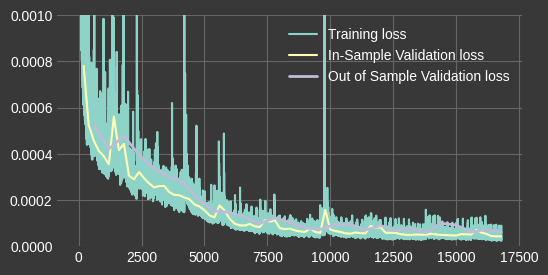

In [34]:
training_loss_history_array = np.array(training_loss_history)
validation_loss_history_array = np.array(validation_loss_history)
withheld_loss_history_array = np.array(withheld_loss_history)

plt.figure(figsize=(6,3))
plt.plot(training_loss_history_array[:,0],training_loss_history_array[:,1], label="Training loss")
plt.plot(validation_loss_history_array[:,0],validation_loss_history_array[:,1], label="In-Sample Validation loss")
plt.plot(withheld_loss_history_array[:,0],withheld_loss_history_array[:,1], lw=2, label="Out of Sample Validation loss")
plt.ylim([0,0.001])
plt.legend()
plt.show()

# Testing

In [19]:
timeseries_model.load_state_dict(torch.load("./checkpoints/202305202148_timeseries_SW.pt")["model_state_dict"])
energy_model.load_state_dict(torch.load("./checkpoints/202305202148_energy_SW.pt")["model_state_dict"])

<All keys matched successfully>

In [35]:
timeseries_model.eval()
energy_model.eval()

EnergyCNN(
  (in_convolutional_layer): Sequential(
    (0): Conv1d(44, 64, kernel_size=(2,), stride=(1,), padding=same)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (out_convolutional_layer): Sequential(
    (0): Conv1d(64, 2, kernel_size=(2,), stride=(1,), padding=same)
    (1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [39]:
all_loads = []
all_results = []
unseen_climates = make_dataset(start_idx=400000, count=2000)
test_dataloader = unseen_climates["dataloaders"]["train"] # fine to use training since it's never been seen
losses = []
print("starting projection")
epws = []
czs = []
temps = []
with torch.no_grad():
    for test_samples in test_dataloader:
        # test_samples = next(iter(test_dataloader))
        timeseries = test_samples["timeseries_vector"].to(device).float()
        bldg_vect = test_samples["building_vector"].to(device).float()
        loads = test_samples["results_vector"].to(device).float()
        # timeseries[:,:7] = 0
        temp = timeseries[:,0]
        # temp = temp[:,:24*30*12]
        # temp = temp.reshape(-1, 12, 30*24)
        # temp = torch.mean(temp, axis=2)
        temps.append(temp)

        # print("bldg_vect: ", bldg_vect.shape)
        # print("timeseries: ", timeseries.shape)
        # print("loads: ", loads.shape)
        timeseries_latvect = timeseries_model(timeseries)
        # print("latent: ", timeseries_latvect.shape)

        # Concatenate vectors
        x = torch.cat([timeseries_latvect, bldg_vect], axis=1)
        x = x.squeeze(1)
        # print("energy input: ", x.shape)

        predicted_loads = energy_model(x)
        all_loads.append(loads)
        all_results.append(predicted_loads)

        # loss = loss_function(loads, predicted_loads)
        # losses.append(loss)

all_loads = torch.vstack(all_loads)
all_results = torch.vstack(all_results)
# all_losses = torch.vstack(losses)
all_temps = torch.vstack(temps)



Calculating mean from batch data for orientation...
starting projection


torch.Size([16000, 8760])


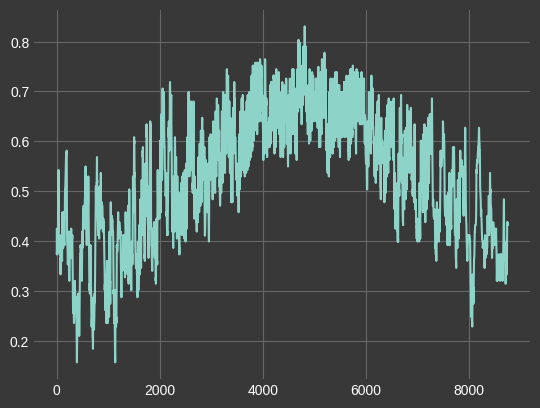

In [37]:
print(all_temps.shape)
plt.plot(all_temps[5].cpu())

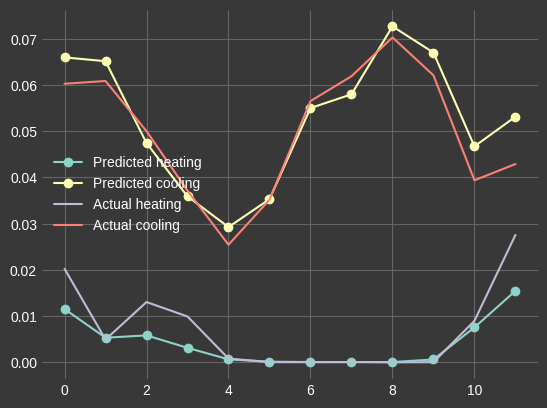

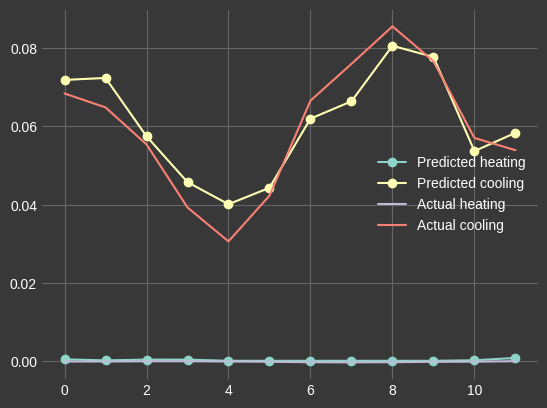

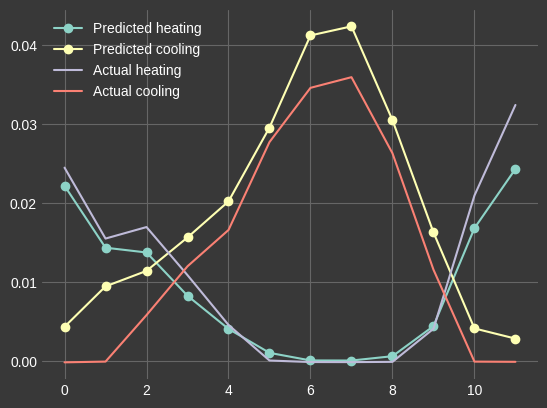

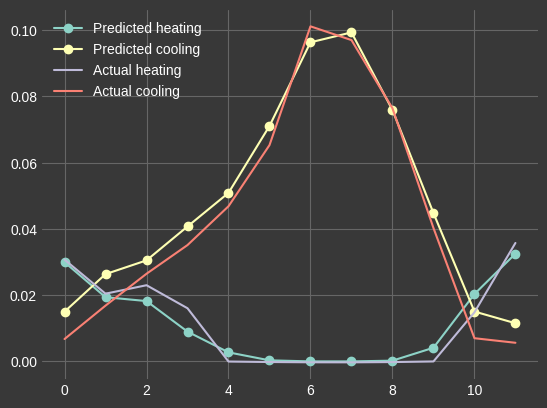

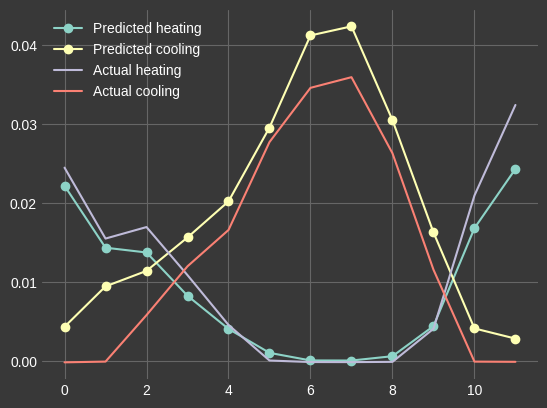

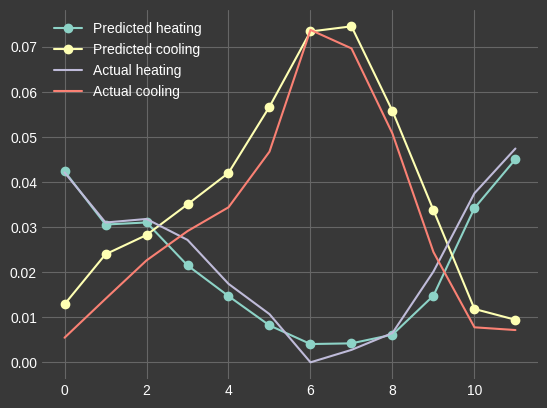

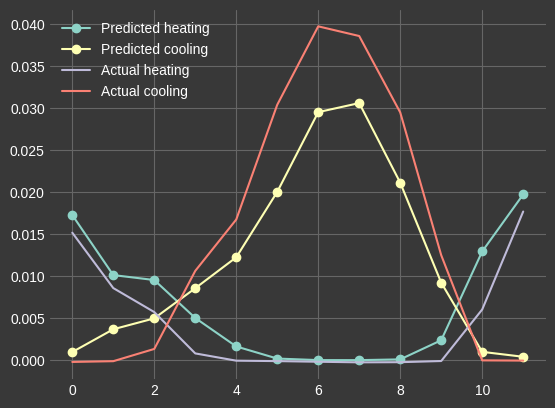

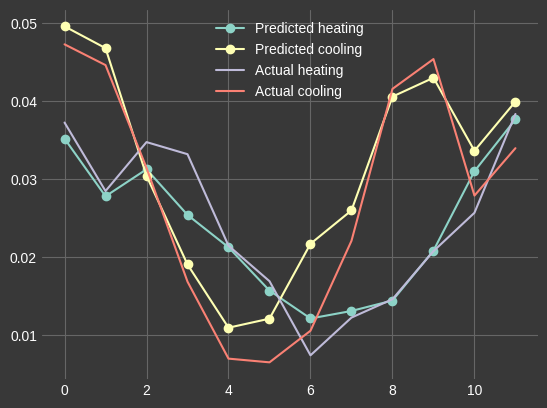

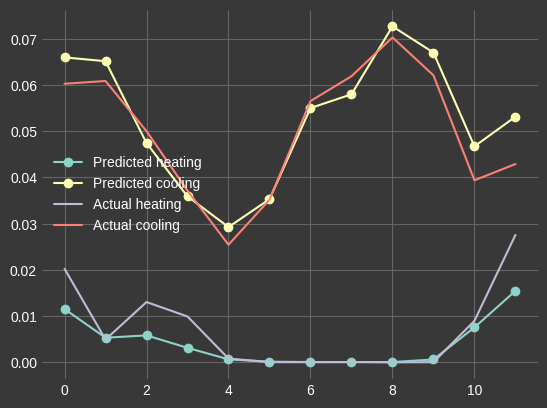

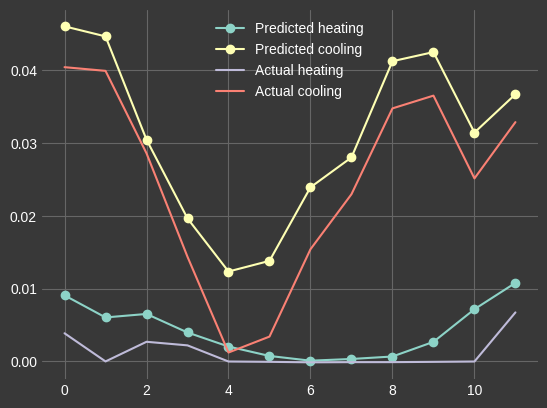

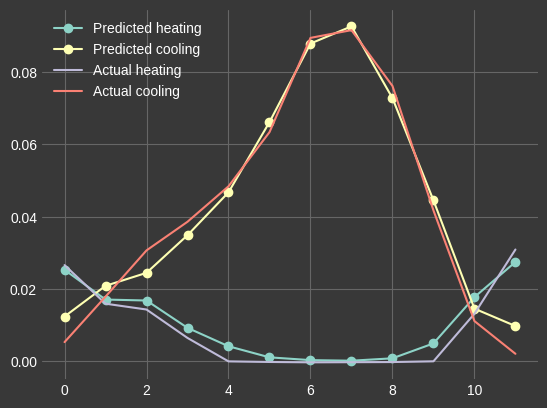

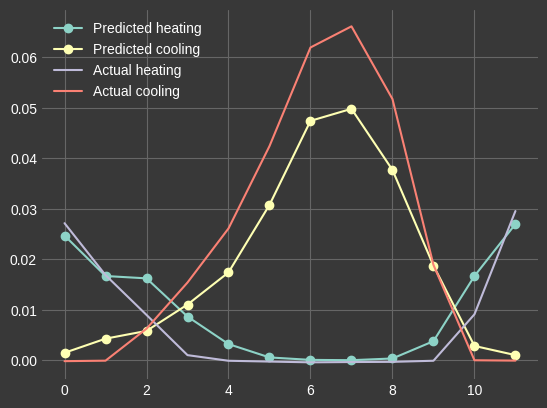

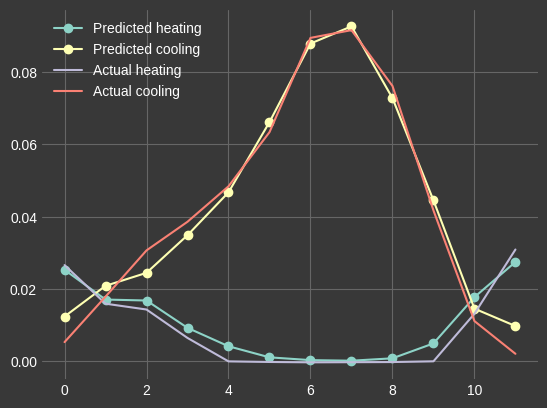

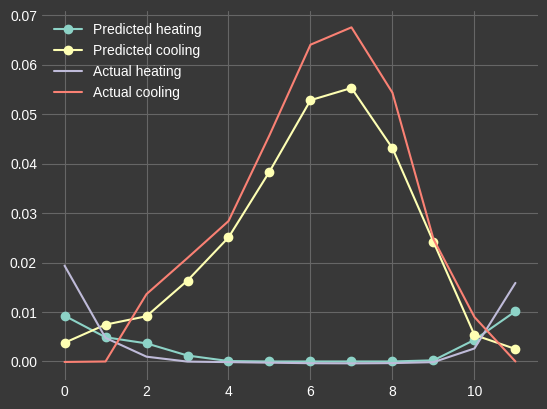

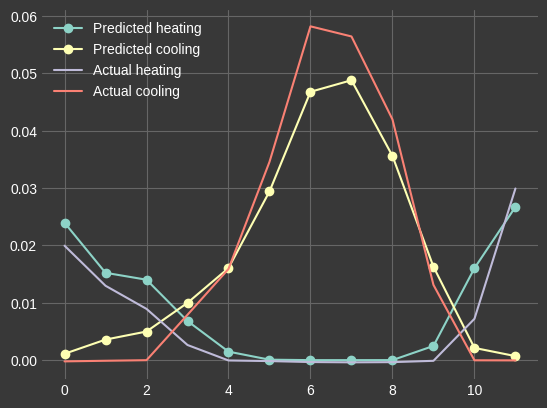

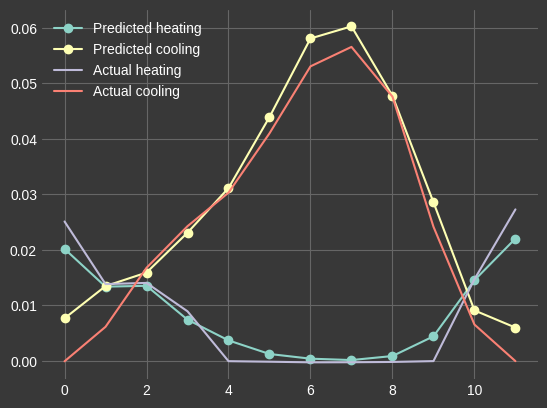

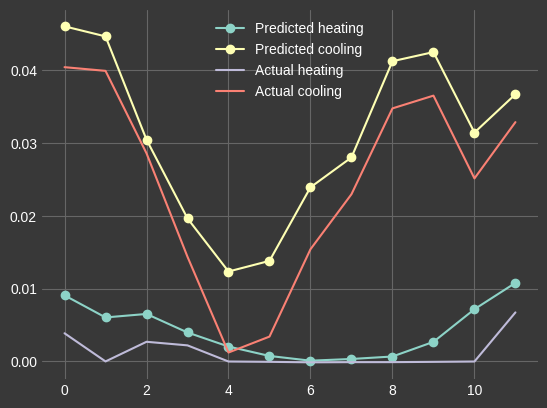

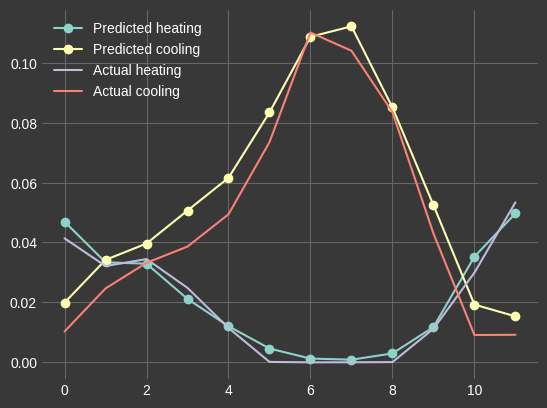

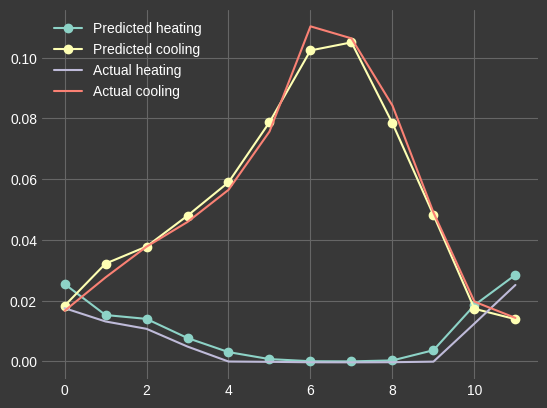

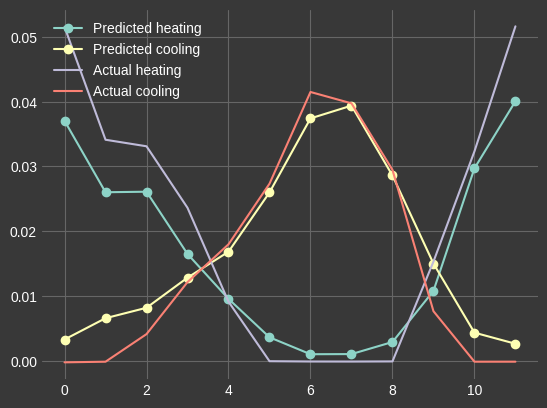

In [40]:
# i = 200
# fig, axs = plt.subplots(5,4)
ix = np.random.choice(np.arange(100), 20)
for idx in range(20):
    i = ix[idx]

    plt.figure()
    # ax = plt.gca().twinx()
    # ax.plot(
    #     all_temps[i].cpu(),
    #     label="Temp",
    # )
    plt.plot(all_loads[i, 0, :].cpu(), "-o",label="Predicted heating")
    plt.plot(all_loads[i, 1, :].cpu(), "-o",label="Predicted cooling")
    plt.plot(all_results[i, 0, :].cpu(), label="Actual heating")
    plt.plot(all_results[i, 1, :].cpu(), label="Actual cooling")
    # plt.ylim([-0.01,0.5])
    plt.legend()
    plt.show()

In [ ]:
# i = 200
for i in range(10):
    plt.figure()
    plt.plot(all_loads[i, 0, :].cpu(), "-o",label="Predicted heating")
    plt.plot(all_loads[i, 1, :].cpu(), "-o",label="Predicted cooling")
    plt.plot(all_results[i, 0, :].cpu(), label="Actual heating")
    plt.plot(all_results[i, 1, :].cpu(), label="Actual cooling")
    plt.ylim([-0.01,0.5])
    plt.legend()
    plt.show()

# Visualizations
- Latent space - T-sne
- 

In [60]:
print(schema)

-------- Schema --------
---- batch_id ----
shape storage: (1,) / shape ml: (0,)
location storage: 0->1 / location ml: 0->0

---- variation_id ----
shape storage: (1,) / shape ml: (0,)
location storage: 1->2 / location ml: 0->0

---- program_type ----
shape storage: (1,) / shape ml: (19,)
location storage: 2->3 / location ml: 0->19

---- vintage ----
shape storage: (1,) / shape ml: (1,)
location storage: 3->4 / location ml: 19->20

---- climate_zone ----
shape storage: (1,) / shape ml: (17,)
location storage: 4->5 / location ml: 20->37

---- base_epw ----
shape storage: (1,) / shape ml: (0,)
location storage: 5->6 / location ml: 37->37

---- width ----
shape storage: (1,) / shape ml: (1,)
location storage: 6->7 / location ml: 37->38

---- height ----
shape storage: (1,) / shape ml: (1,)
location storage: 7->8 / location ml: 38->39

---- facade_2_footprint ----
shape storage: (1,) / shape ml: (1,)
location storage: 8->9 / location ml: 39->40

---- perim_2_footprint ----
shape storage: (

(array([10060., 40661., 62755., 56703., 13366., 82703., 11494., 93906.,
            0., 28352.]),
 array([ 2. ,  3.4,  4.8,  6.2,  7.6,  9. , 10.4, 11.8, 13.2, 14.6, 16. ]),
 <BarContainer object of 10 artists>)

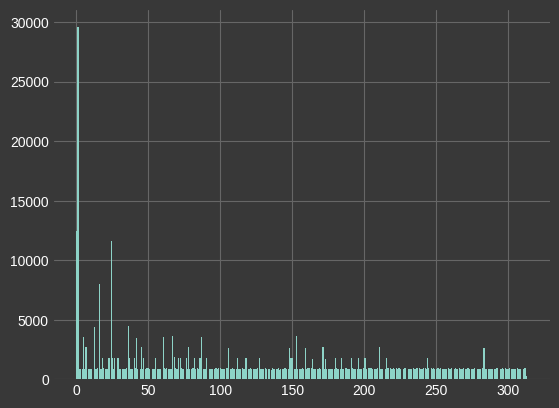

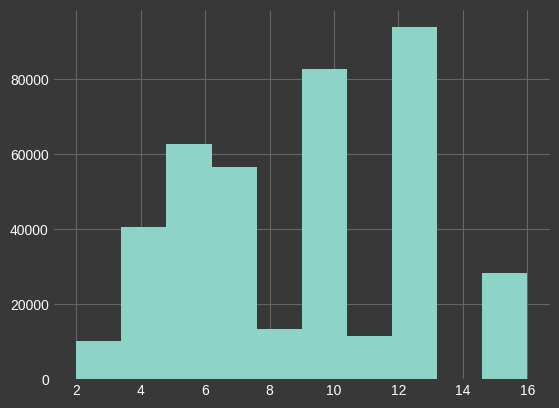

In [62]:
with h5py.File("./data/hdf5/all_data_monthly.hdf5", "r") as f:
    epw = f["storage_batch"][0:train_test_split_idx, 5]
    cz = f["storage_batch"][0:train_test_split_idx, 4]


plt.figure()
plt.hist(epw, bins=392)
plt.figure()
plt.hist(cz)


(array([ 1530., 14051., 18621., 12260.,  3561., 31896.,  5286., 27605.,
            0.,  5231.]),
 array([ 2. ,  3.4,  4.8,  6.2,  7.6,  9. , 10.4, 11.8, 13.2, 14.6, 16. ]),
 <BarContainer object of 10 artists>)

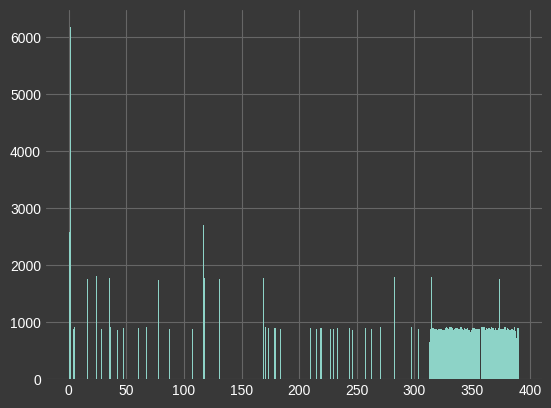

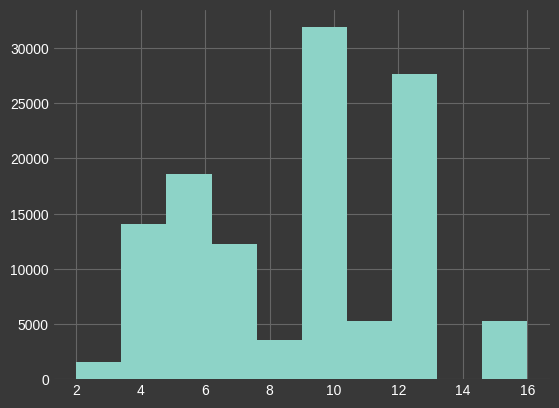

In [63]:

with h5py.File("./data/hdf5/all_data_monthly.hdf5", "r") as f:
    epw = f["storage_batch"][train_test_split_idx:, 5]
    cz = f["storage_batch"][train_test_split_idx:, 4]


plt.figure()
plt.hist(epw, bins=392)
plt.figure()
plt.hist(cz)